In [10]:
import numpy as np
import pandas as pd
import sklearn as sk
df_all = pd.read_csv("sample_data/bank-full.csv", sep=";")
df = df_all[['age', 'job', 'marital','education','balance','housing','contact','day','month','duration','campaign','pdays','previous','poutcome','y']]
df['y'] = df['y'].map({'yes': 1, 'no': 0})

<ipython-input-10-e4bc4f083f09>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y'] = df['y'].map({'yes': 1, 'no': 0})


In [11]:
from sklearn.model_selection import train_test_split
X = df.drop("y", axis = 1)
y = df[["y"]]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Вопрос 1: Какая числовая переменная (из следующих 4) имеет наивысший AUC?

In [12]:
from sklearn.metrics import roc_auc_score
numerical_features = df.select_dtypes(include = ["int", "float"]).columns
auc_scores = {}

for feature in numerical_features:
  auc = roc_auc_score(df["y"], df[feature])
  if auc < 0.5:
    auc = roc_auc_score(df["y"], -df[feature])
  auc_scores[feature] = auc

auc_scores = sorted(auc_scores.items(), key=lambda x: x[1], reverse = True)
print(auc_scores)

[('y', 1.0), ('duration', 0.8075955951124923), ('previous', 0.6023034054239005), ('pdays', 0.593224032562116), ('balance', 0.590061489160812), ('campaign', 0.5723342144142696), ('day', 0.5265199356555834), ('age', 0.5078552662471552)]


Ответ: duration

# Вопрос 2: Какой AUC у этой модели на валидационном наборе данных?

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

train_dict = X_train.to_dict(orient='records')
val_dict = X_val.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict_proba(X_val)[:, 1]
roc_auc = roc_auc_score(y_val, y_pred)

print(roc_auc)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9001827055571039


# Вопрос 3: На каком пороге precision и recall пересекаются?
# Вопрос 4: При каком пороге F1 достигает максимума?

<ipython-input-14-a8a0388c0bd5>:19: RuntimeWarning: invalid value encountered in scalar divide
  F1.append(round(2*(precision*recall/(precision+recall)), 2))


Max_threshold: 0.19 max F1: 0.58


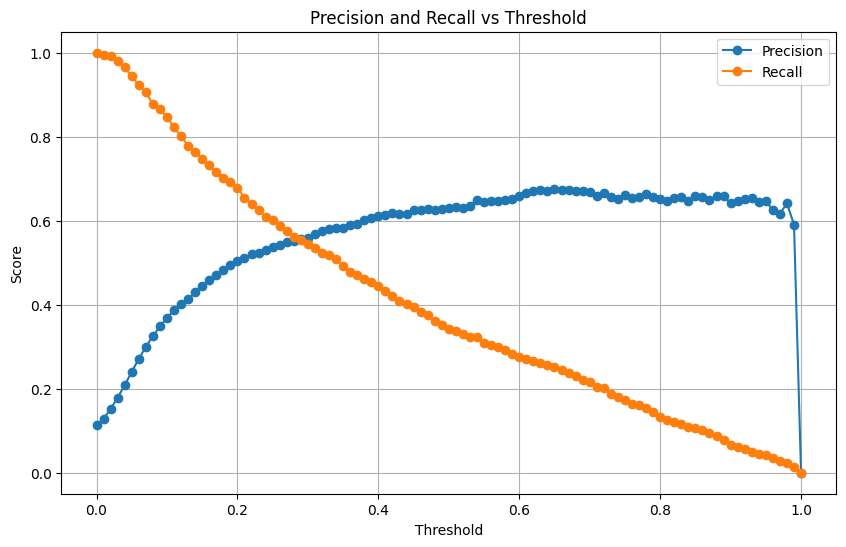

Пересечение: 0.29


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

y_pred_prob = model.predict_proba(X_val)[:, 1]

thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []
F1 = []

for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)

    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)

    precisions.append(precision)
    recalls.append(recall)
    F1.append(round(2*(precision*recall/(precision+recall)), 2))

print("Max_threshold:", F1.index(max(F1))/100, "max F1:", max(F1))
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', marker='o')
plt.plot(thresholds, recalls, label='Recall', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

for i in range(len(thresholds)):
    if np.isclose(precisions[i], recalls[i], atol=0.01):
        print(f"Пересечение: {thresholds[i]:.2f}")
        break

F1 максимум при 0.56

# Вопрос 5: Какова стандартная ошибка оценок на разных фолдах?

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np

kf = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores = []

for train_index, val_index in kf.split(X_train):
    if isinstance(X_train, np.ndarray):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    else:
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]

    if isinstance(y_train, np.ndarray):
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    else:
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    if isinstance(X_train_fold, np.ndarray):
        train_dict = [dict(zip(range(X_train_fold.shape[1]), row)) for row in X_train_fold]
        val_dict = [dict(zip(range(X_val_fold.shape[1]), row)) for row in X_val_fold]
    else:
        train_dict = X_train_fold.to_dict(orient='records')
        val_dict = X_val_fold.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train_encoded = dv.fit_transform(train_dict)
    X_val_encoded = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_encoded, y_train_fold)

    y_pred = model.predict_proba(X_val_encoded)[:, 1]

    auc = roc_auc_score(y_val_fold, y_pred)
    auc_scores.append(auc)

    print(f"AUC на текущем фолде: {auc:.3f}")

mean_auc = np.mean(auc_scores)
std_auc = np.std(auc_scores)

se_auc = std_auc / np.sqrt(len(auc_scores))

print(f"\nСреднее значение AUC по всем фолдам: {mean_auc:.3f}")
print(f"Стандартное отклонение AUC по всем фолдам: {std_auc:.3f}")
print(f"Стандартная ошибка AUC: {se_auc:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC на текущем фолде: 0.909


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC на текущем фолде: 0.914


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC на текущем фолде: 0.902


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC на текущем фолде: 0.904


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AUC на текущем фолде: 0.910

Среднее значение AUC по всем фолдам: 0.908
Стандартное отклонение AUC по всем фолдам: 0.004
Стандартная ошибка AUC: 0.002


# Вопрос 6: Какое значение C приводит к лучшему среднему значению?

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

data = pd.read_csv('sample_data/bank-full.csv', sep=';')

columns_to_keep = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
    'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]
data = data[columns_to_keep]

data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

data = pd.get_dummies(data, columns=['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome'])

X = data.drop(columns=['y'])
y = data['y']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)

kfold = KFold(n_splits=5, shuffle=True, random_state=1)

C_values = [0.000001, 0.001, 1]

best_C = None
best_mean_score = -np.inf
best_std = np.inf

for C in C_values:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('log_reg', LogisticRegression(solver='liblinear', C=C, max_iter=1000))
    ])

    scores = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    mean_score = round(scores.mean(), 3)
    std_score = round(scores.std(), 3)

    print(f'C={C}: mean={mean_score}, std={std_score}')

    if mean_score > best_mean_score or (mean_score == best_mean_score and std_score < best_std):
        best_C = C
        best_mean_score = mean_score
        best_std = std_score

print(f'Лучшее значение C: {best_C}, средняя оценка: {best_mean_score}, стандартное отклонение: {best_std}')

C=1e-06: mean=0.884, std=0.003
C=0.001: mean=0.901, std=0.004
C=1: mean=0.902, std=0.005
Лучшее значение C: 1, средняя оценка: 0.902, стандартное отклонение: 0.005


1. duration
2. 0.9
3. 0.29
4. 0.56
5. 0.002
6. 1